In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import bioframe

In [2]:
def get_links(peaks, genes, cutoff_distance):
    peaks = peaks[peaks['chrom'] != 'chrX']
    genes = genes[genes['chrom'] != 'chrX']
    links = []
    for peak in peaks.values:   
        for gene in genes.values:
            chrom_peak = peak[0]
            pos_peak = (peak[1]+peak[2])//2

            chrom_gene = gene[0]
            if gene[3] == '+':
                pos_gene = gene[1]
            else:
                pos_gene = gene[2]

            if chrom_peak == chrom_gene and abs(pos_peak-pos_gene) <= cutoff_distance:
                links.append(np.hstack((np.hstack((peak, gene)), [abs(pos_peak-pos_gene)])))

    links = pd.DataFrame(links)
    links.columns = ['chrom_peak', 'start_peak', 'end_peak', 'peak_id', 'baseMean_peak', 'log2FoldChange_peak', 'FDR_peak',
                     'chrom_gene', 'start_gene', 'end_gene', 'strand_gene', 'gene_type', 'gene_name', 'gene_id', 'baseMean_gene', 'log2FoldChange_gene', 'FDR_gene', 'distance']
    links['link_id'] = ['link_' + str(x) for x in np.arange(len(links))+1]
    return(links)

In [36]:
imp_genes = pd.read_csv('/DATA/users/m.magnitov/hap_phen/TTseq/public_data/imprinted_genes_geneimprint.txt', sep = '\t', header = None)
imp_genes_list = np.unique(imp_genes[0].values)
print('Imprinted genes:', len(imp_genes_list))

ig_genes = pd.read_csv('/DATA/users/m.magnitov/hap_phen/TTseq/public_data/immunoglobulin_complex_go_0019814.txt', sep = '\t', header = None)
ig_genes_list = np.unique(ig_genes[0].values)
print('IG genes:', len(ig_genes_list))

mhc_genes = pd.read_csv('/DATA/users/m.magnitov/hap_phen/TTseq/public_data/mhc_protein_complex_go_0042611.txt', sep = '\t', header = None)
mhc_genes_list = np.unique(mhc_genes[0].values)
print('MHC genes:', len(mhc_genes_list))

genes_to_filter = list(imp_genes_list) + list(ig_genes_list) + list(mhc_genes_list)

Imprinted genes: 118
IG genes: 273
MHC genes: 143


### Create links

In [91]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    ase = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/TTseq/ase/{sample}_allele_specific.bed', sep = '\t',
                      names = ['chrom', 'start', 'end', 'strand', 'gene_type', 'gene_name', 'gene_id', 'baseMean', 'log2FoldChange', 'FDR'])
    
    ase['gene_id_no_version'] = [x.split('.')[0] for x in ase['gene_id'].values]
    ase = ase[~ase['gene_id_no_version'].isin(genes_to_filter)]
    ase = ase.drop('gene_id_no_version', axis = 1)
    
    asocr = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_allele_specific.bed', sep = '\t',
                        names = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR'])
    links = get_links(asocr, ase, 1000000)
    print(sample, len(links))
    links.to_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 1, index = 0)

NA12878 440
NA18983 572
HG01241 428
HG02601 393
HG03464 1397


In [92]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    balanced_expression = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/TTseq/ase/{sample}_balanced.bed', sep = '\t',
                                      names = ['chrom', 'start', 'end', 'strand', 'gene_type', 'gene_name', 'gene_id', 'baseMean', 'log2FoldChange', 'FDR'])
    
    balanced_expression['gene_id_no_version'] = [x.split('.')[0] for x in balanced_expression['gene_id'].values]
    balanced_expression = balanced_expression[~balanced_expression['gene_id_no_version'].isin(genes_to_filter)]
    balanced_expression = balanced_expression.drop('gene_id_no_version', axis = 1)
    
    balanced_accessibility = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_balanced.bed', sep = '\t',
                                         names = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR'])
    links = get_links(balanced_accessibility, balanced_expression, 1000000)
    print(sample, len(links))
    links.to_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 1, index = 0)

NA12878 208923
NA18983 206909
HG01241 271995
HG02601 192546
HG03464 364024


In [4]:
links_stats_allele_specific, links_stats_balanced = [], []
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    links_stats_allele_specific.append(len(pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)))
    links_stats_balanced.append(len(pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)))

links_stats = pd.DataFrame([links_stats_allele_specific, links_stats_balanced]).transpose()
links_stats.index = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
links_stats.columns = ['Allele-specific', 'Balanced']
links_stats

,Allele-specific,Balanced
NA12878,440,208923
NA18983,572,206909
HG01241,428,271995
HG02601,393,192546
HG03464,1397,364024


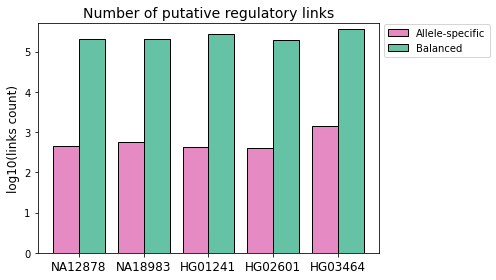

In [34]:
plt.figure(figsize = (7, 4))
plt.title('Number of putative regulatory links', fontsize = 14)
plt.bar(np.arange(5)-0.2, np.log10(links_stats['Allele-specific']), width = 0.4, color = '#E68AC3', edgecolor = 'k', label = 'Allele-specific')
plt.bar(np.arange(5)+0.2, np.log10(links_stats['Balanced']), width = 0.4, color = '#66C2A5', edgecolor = 'k', label = 'Balanced')
plt.ylim((0, np.log10(500000)))
plt.xticks(np.arange(5), ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 12)
plt.ylabel('log10(links count)', fontsize = 12)
plt.legend(bbox_to_anchor = (1, 1.02))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_number.pdf', bbox_inches = 'tight')
plt.show()

### Distance of links

In [94]:
links_allele_specific_distances, links_balanced_distances = [], []
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_allele_specific_distances = links_allele_specific_distances + list(links_allele_specific['distance'])
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    links_balanced_distances = links_balanced_distances + list(links_balanced['distance'])

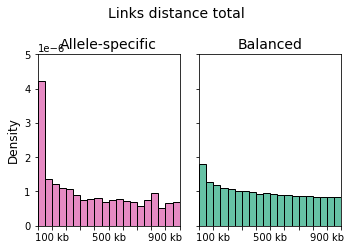

In [95]:
plt.figure(figsize = (5, 3.5))
plt.suptitle(f'Links distance total', fontsize = 14)
    
plt.subplot(121)
plt.title('Allele-specific', fontsize = 14)
plt.hist(links_allele_specific_distances, color = '#E68AC3', edgecolor = 'k', bins = 20, density = True, linewidth = 1)
plt.xlim((0, 1000000))
plt.xticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000], 
           ['', '100 kb', '', '', '', '500 kb', '', '', '', '900 kb', ''])
plt.ylabel('Density', fontsize = 12)
plt.xlim((0, 1000000))
plt.ylim((0, 0.000005))

plt.subplot(122)
plt.title('Balanced', fontsize = 14)
plt.hist(links_balanced_distances, color = '#66C2A5', edgecolor = 'k', bins = 20, density = True, linewidth = 1)
plt.xlim((0, 1000000))
plt.xticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000], 
           ['', '100 kb', '', '', '', '500 kb', '', '', '', '900 kb', ''])
plt.yticks(np.array([0, 1, 2, 3, 4, 5])/1000000, [])
plt.xlim((0, 1000000))
plt.ylim((0, 0.000005))

plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_distance_merged.pdf', bbox_inches = 'tight')
plt.show()

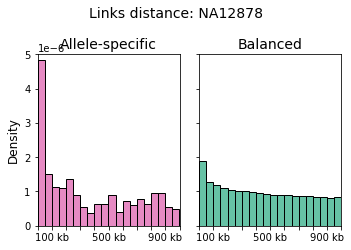

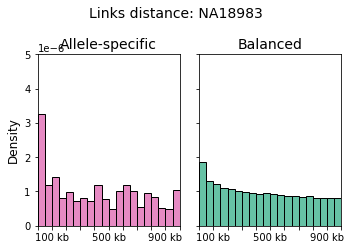

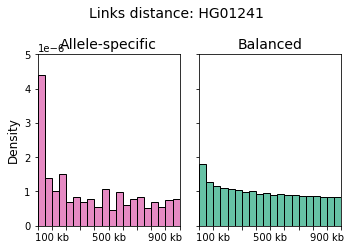

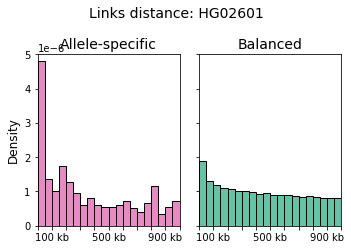

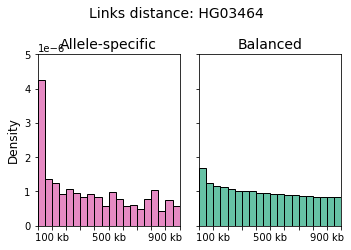

In [96]:
colors = {'NA12878': 'C0', 'NA18983': 'C2', 'HG01241': 'C3', 'HG02601': 'C4', 'HG03464': 'C1'}

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    links_allele_specific_distances, links_balanced_distances = [], []
    
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_allele_specific_distances = links_allele_specific_distances + list(links_allele_specific['distance'])
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    links_balanced_distances = links_balanced_distances + list(links_balanced['distance'])

    plt.figure(figsize = (5, 3.5))
    plt.suptitle(f'Links distance: {sample}', fontsize = 14)

    plt.subplot(121)
    plt.title('Allele-specific', fontsize = 14)
    plt.hist(links_allele_specific_distances, color = '#E68AC3', edgecolor = 'k', bins = 20, density = True, linewidth = 1)
    plt.xlim((0, 1000000))
    plt.xticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000], 
               ['', '100 kb', '', '', '', '500 kb', '', '', '', '900 kb', ''])
    plt.ylabel('Density', fontsize = 12)
    plt.xlim((0, 1000000))
    plt.ylim((0, 0.000005))

    plt.subplot(122)
    plt.title('Balanced', fontsize = 14)
    plt.hist(links_balanced_distances, color = '#66C2A5', edgecolor = 'k', bins = 20, density = True, linewidth = 1)
    plt.xlim((0, 1000000))
    plt.xticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000], 
               ['', '100 kb', '', '', '', '500 kb', '', '', '', '900 kb', ''])
    plt.yticks(np.array([0, 1, 2, 3, 4, 5])/1000000, [])
    plt.xlim((0, 1000000))
    plt.ylim((0, 0.000005))

    plt.tight_layout()
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/figures/links_distance_{sample}.pdf', bbox_inches = 'tight')
    plt.show()

## Fraction of genes linked

In [134]:
links_per_gene_counts = pd.DataFrame()

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    ase = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/TTseq/ase/{sample}_allele_specific.bed', sep = '\t',
                        names = ['chrom', 'start', 'end', 'strand', 'gene_type', 'gene_name', 'gene_id', 'baseMean', 'log2FoldChange', 'FDR'])
    ase['gene_id_no_version'] = [x.split('.')[0] for x in ase['gene_id'].values]
    
    excluded_chrX_genes = len(ase)-len(ase[ase['chrom'] != 'chrX'])
    excluded_other_genes = len(ase)-len(ase[~ase['gene_id_no_version'].isin(genes_to_filter)])
    
    ase = ase[~ase['gene_id_no_version'].isin(genes_to_filter)]
    ase = ase.drop('gene_id_no_version', axis = 1)
    ase = ase[ase['chrom'] != 'chrX']
    
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_allele_specific = links_allele_specific[links_allele_specific['gene_id'].isin(ase['gene_id'].values)]
    linked_genes = np.unique(links_allele_specific['gene_id'], return_counts = 1)[1]
    linked_genes_unique = len([x for x in linked_genes if x == 1])
    linked_genes_multi = len([x for x in linked_genes if x != 1])
    not_linked_genes = len(ase)-linked_genes_unique-linked_genes_multi
    
    links_per_gene = [linked_genes_multi, linked_genes_unique, not_linked_genes, 
                      excluded_chrX_genes, excluded_other_genes][::-1]
    links_per_gene_counts[sample] = links_per_gene
    
links_per_gene_counts.columns = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
links_per_gene_counts

,NA12878,NA18983,HG01241,HG02601,HG03464
0,10,15,20,20,23
1,199,0,0,147,260
2,73,96,200,136,93
3,80,97,150,121,134
4,119,130,93,85,351


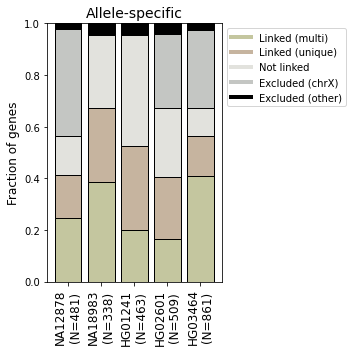

In [139]:
plt.figure(figsize = (5, 5))
plt.title('Allele-specific', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_gene_counts[sample][p:])/np.sum(links_per_gene_counts[sample]) for p in range(5)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['k', '#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_gene_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_gene_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_gene_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_gene_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_gene_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of genes', fontsize = 12)
plt.ylim((0, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)', 'Excluded (other)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_genes_allele_specific.pdf', bbox_inches = 'tight')
plt.show()

In [140]:
links_per_gene_counts = pd.DataFrame()

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/TTseq/ase/{sample}_balanced.bed', sep = '\t',
                        names = ['chrom', 'start', 'end', 'strand', 'gene_type', 'gene_name', 'gene_id', 'baseMean', 'log2FoldChange', 'FDR'])
    balanced['gene_id_no_version'] = [x.split('.')[0] for x in balanced['gene_id'].values]
    
    excluded_chrX_genes = len(balanced)-len(balanced[balanced['chrom'] != 'chrX'])
    excluded_other_genes = len(balanced)-len(balanced[~balanced['gene_id_no_version'].isin(genes_to_filter)])
    
    balanced = balanced[~balanced['gene_id_no_version'].isin(genes_to_filter)]
    balanced = balanced.drop('gene_id_no_version', axis = 1)
    balanced = balanced[balanced['chrom'] != 'chrX']
    
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    links_balanced = links_balanced[links_balanced['gene_id'].isin(balanced['gene_id'].values)]

    linked_genes = np.unique(links_balanced['gene_id'], return_counts = 1)[1]
    linked_genes_unique = len([x for x in linked_genes if x == 1])
    linked_genes_multi = len([x for x in linked_genes if x != 1])
    not_linked_genes = len(balanced)-linked_genes_unique-linked_genes_multi
    
    links_per_gene = [linked_genes_multi, linked_genes_unique, not_linked_genes, 
                      excluded_chrX_genes, excluded_other_genes][::-1]
    links_per_gene_counts[sample] = links_per_gene
    
links_per_gene_counts.columns = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
links_per_gene_counts

,NA12878,NA18983,HG01241,HG02601,HG03464
0,53,48,48,50,53
1,83,0,0,97,90
2,56,23,19,34,15
3,45,19,23,55,16
4,11235,9980,12012,10861,12275


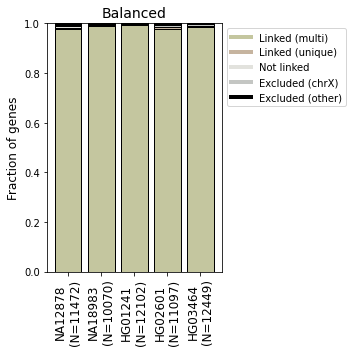

In [141]:
plt.figure(figsize = (5, 5))
plt.title('Balanced', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_gene_counts[sample][p:])/np.sum(links_per_gene_counts[sample]) for p in range(5)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['k', '#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_gene_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_gene_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_gene_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_gene_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_gene_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of genes', fontsize = 12)
plt.ylim((0, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)', 'Excluded (other)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_genes_balanced.pdf', bbox_inches = 'tight')
plt.show()

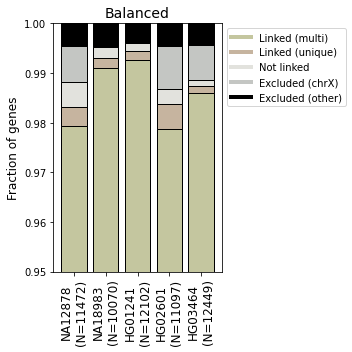

In [142]:
plt.figure(figsize = (5, 5))
plt.title('Balanced', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_gene_counts[sample][p:])/np.sum(links_per_gene_counts[sample]) for p in range(5)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['k', '#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_gene_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_gene_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_gene_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_gene_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_gene_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of genes', fontsize = 12)
plt.ylim((0.95, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)', 'Excluded (other)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_genes_balanced_zoomed.pdf', bbox_inches = 'tight')
plt.show()

## Fraction of peaks linked

In [143]:
links_per_peak_counts = pd.DataFrame()

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    asocr = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_allele_specific.bed', sep = '\t',
                        names = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR'])
    excluded_chrX_peaks = len(asocr)-len(asocr[asocr['chrom'] != 'chrX'])
    
    asocr = asocr[asocr['chrom'] != 'chrX']
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)    

    links_allele_specific = links_allele_specific[links_allele_specific['peak_id'].isin(asocr['peak_id'].values)]
    
    linked_peaks = np.unique(links_allele_specific['peak_id'], return_counts = 1)[1]
    linked_peaks_unique = len([x for x in linked_peaks if x == 1])
    linked_peaks_multi = len([x for x in linked_peaks if x != 1])
    not_linked_peaks = len(asocr)-linked_peaks_unique-linked_peaks_multi
    
    links_per_peak = [linked_peaks_multi, linked_peaks_unique, not_linked_peaks, excluded_chrX_peaks][::-1]
    links_per_peak_counts[sample] = links_per_peak
    
links_per_peak_counts.columns = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
links_per_peak_counts

,NA12878,NA18983,HG01241,HG02601,HG03464
0,177,0,0,132,389
1,613,1023,328,438,1077
2,163,265,136,152,461
3,107,109,96,91,336


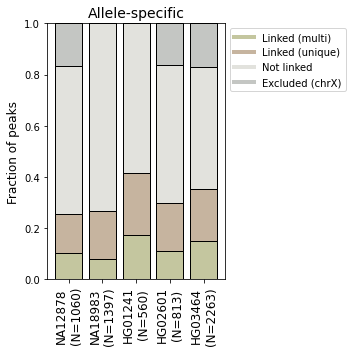

In [144]:
plt.figure(figsize = (5, 5))
plt.title('Allele-specific', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_peak_counts[sample][p:])/np.sum(links_per_peak_counts[sample]) for p in range(4)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_peak_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_peak_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_peak_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_peak_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_peak_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of peaks', fontsize = 12)
plt.ylim((0, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_peaks_allele_specific.pdf', bbox_inches = 'tight')
plt.show()

In [145]:
links_per_peak_counts = pd.DataFrame()

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    balanced = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_balanced.bed', sep = '\t',
                        names = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR'])
    excluded_chrX_peaks = len(balanced)-len(balanced[balanced['chrom'] != 'chrX'])
    
    balanced = balanced[balanced['chrom'] != 'chrX']
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)    

    links_balanced = links_balanced[links_balanced['peak_id'].isin(balanced['peak_id'].values)]
    
    linked_peaks = np.unique(links_balanced['peak_id'], return_counts = 1)[1]
    linked_peaks_unique = len([x for x in linked_peaks if x == 1])
    linked_peaks_multi = len([x for x in linked_peaks if x != 1])
    not_linked_peaks = len(balanced)-linked_peaks_unique-linked_peaks_multi
    
    links_per_peak = [linked_peaks_multi, linked_peaks_unique, not_linked_peaks, excluded_chrX_peaks][::-1]
    links_per_peak_counts[sample] = links_per_peak
    
links_per_peak_counts.columns = ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']
links_per_peak_counts

,NA12878,NA18983,HG01241,HG02601,HG03464
0,139,0,0,104,213
1,356,559,248,184,484
2,441,655,348,335,452
3,15014,17548,17809,13570,24364


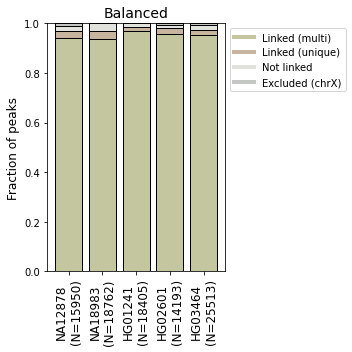

In [146]:
plt.figure(figsize = (5, 5))
plt.title('Balanced', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_peak_counts[sample][p:])/np.sum(links_per_peak_counts[sample]) for p in range(4)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_peak_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_peak_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_peak_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_peak_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_peak_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of peaks', fontsize = 12)
plt.ylim((0, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_peaks_balanced.pdf', bbox_inches = 'tight')
plt.show()

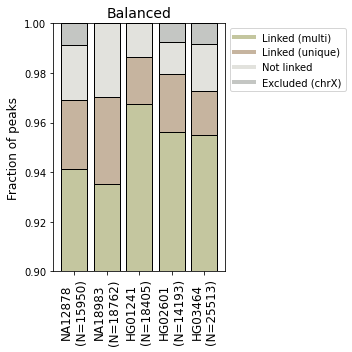

In [148]:
plt.figure(figsize = (5, 5))
plt.title('Balanced', fontsize = 14)

for (i, sample) in enumerate(['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']):
    fractions = [np.sum(links_per_peak_counts[sample][p:])/np.sum(links_per_peak_counts[sample]) for p in range(4)]
    plt.bar(x = [i]*len(fractions), height = fractions, color = ['#c4c6c3', '#e2e2dd', '#C6B49F', '#C4C69F'], edgecolor = 'k')

plt.xticks(np.arange(5), [f"NA12878\n(N={np.sum(links_per_peak_counts['NA12878'])})", 
                          f"NA18983\n(N={np.sum(links_per_peak_counts['NA18983'])})",
                          f"HG01241\n(N={np.sum(links_per_peak_counts['HG01241'])})",
                          f"HG02601\n(N={np.sum(links_per_peak_counts['HG02601'])})",
                          f"HG03464\n(N={np.sum(links_per_peak_counts['HG03464'])})"], rotation = 90, fontsize = 12)
plt.ylabel('Fraction of peaks', fontsize = 12)
plt.ylim((0.9, 1))
custom_lines = [Line2D([0], [0], color='#C4C69F', lw=4),
                Line2D([0], [0], color='#C6B49F', lw=4),
                Line2D([0], [0], color='#e2e2dd', lw=4),
                Line2D([0], [0], color='#c4c6c3', lw=4)]
plt.legend(custom_lines, ['Linked (multi)', 'Linked (unique)', 'Not linked', 'Excluded (chrX)'], bbox_to_anchor = (1, 1))
plt.tight_layout()
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/links_linked_peaks_balanced_zoomed.pdf', bbox_inches = 'tight')
plt.show()

## Number of variants in peaks for links

In [3]:
def read_variants(sample):
    variants = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/{sample}.phased.het.bed', 
                           sep = '\t', header = None)
    variants[11] = [int(x.split('|')[0]) for x in variants[10].values]
    variants[12] = [int(x.split('|')[1].split(':')[0]) for x in variants[10].values]
    variants = variants[[0, 2, 2, 3, 5, 6, 11, 12]]
    variants.columns = ['chrom', 'start', 'end', 'variant_id', 'ref', 'alt', 'allele_ref', 'allele_alt']
    return(variants)

def get_variants_for_links(phased_variants, links):
    phased_variants_overlap_links = bioframe.overlap(phased_variants, links,  
                                                     cols2 = ('chrom_peak', 'start_peak', 'end_peak'),
                                                     suffixes = ('_variant', ''))
    phased_variants_overlap_links = phased_variants_overlap_links.dropna()
    phased_variants_overlap_links = phased_variants_overlap_links.drop('distance', axis = 1)

    putative_non_overlaps = links[~links['peak_id'].isin(phased_variants_overlap_links['peak_id'])]['peak_id'].values
    if len(putative_non_overlaps) != 0:
        links_non_overlaps = links[links['peak_id'].isin(putative_non_overlaps)]

        phased_variants_overlap_non_overlaps = bioframe.closest(links_non_overlaps, phased_variants, 
                     cols1 = ('chrom_peak', 'start_peak', 'end_peak'),
                     suffixes = ('', '_variant'))
        sort_order = list(phased_variants_overlap_non_overlaps.columns[-9:]) + list(phased_variants_overlap_non_overlaps.columns[:-9])
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps[sort_order]
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps.drop('distance', axis = 1)

    phased_variants_overlap_links = pd.concat([phased_variants_overlap_links, phased_variants_overlap_non_overlaps], ignore_index = True)
    phased_variants_overlap_links = phased_variants_overlap_links.sort_values(['chrom_variant', 'start_variant'])
    phased_variants_overlap_links.index = np.arange(len(phased_variants_overlap_links))
    phased_variants_overlap_links['gene_id'] = [x.split('.')[0] for x in phased_variants_overlap_links['gene_id']]
    phased_variants_overlap_links['variant_link_id'] = ['variant_link_' + str(x) for x in np.arange(len(phased_variants_overlap_links))+1]
    return(phased_variants_overlap_links)

def read_significant_gtex_data(tissue_name):
    gtex_data = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/links/gtex_data/{tissue_name}.v8.signif_variant_gene_pairs.txt.gz', sep = '\t')
    gtex_data['chrom'] = [x.split('_')[0] for x in gtex_data['variant_id']]
    gtex_data['start'] = [int(x.split('_')[1]) for x in gtex_data['variant_id']]
    gtex_data['end'] = [int(x.split('_')[1]) for x in gtex_data['variant_id']]
    gtex_data['ref'] = [x.split('_')[2] for x in gtex_data['variant_id']]
    gtex_data['alt'] = [x.split('_')[3] for x in gtex_data['variant_id']]
    gtex_data['gene_id'] = [x.split('.')[0] for x in gtex_data['gene_id']]
    gtex_data = gtex_data[['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'maf', 'slope']]
    return(gtex_data)

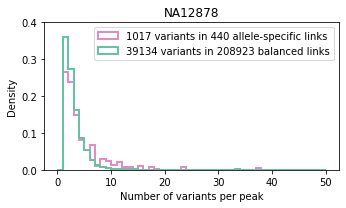

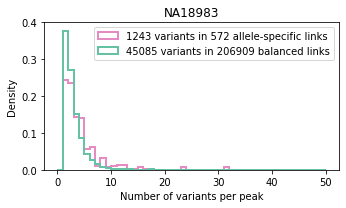

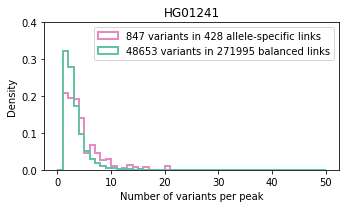

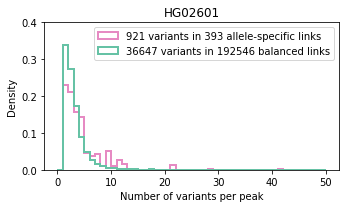

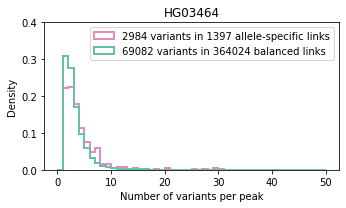

In [41]:
for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    phased_variants = read_variants(sample)
    
    links_allele_specific = pd.read_csv(f'links_{sample}_allele_specific.txt', sep = '\t', header = 0)
    links_balanced = pd.read_csv(f'links_{sample}_balanced.txt', sep = '\t', header = 0)
    
    variants_links_allele_specific = get_variants_for_links(phased_variants, links_allele_specific)
    variants_links_balanced = get_variants_for_links(phased_variants, links_balanced)
    
    plt.figure(figsize = (5, 3))
    plt.title(f"{sample}")
    plt.hist(np.unique(variants_links_allele_specific['link_id'], return_counts = 1)[1], range = (0, 50), bins = 50, 
             density = True, color = '#E68AC3', histtype = 'step', lw = 2, 
             label = f"{len(np.unique(variants_links_allele_specific['variant_id_variant']))} variants in {len(np.unique(variants_links_allele_specific['link_id']))} allele-specific links")
    plt.hist(np.unique(variants_links_balanced['link_id'], return_counts = 1)[1], range = (0, 50), bins = 50, 
             density = True, color = '#66C2A5', histtype = 'step', lw = 2,
             label = f"{len(np.unique(variants_links_balanced['variant_id_variant']))} variants in {len(np.unique(variants_links_balanced['link_id']))} balanced links")
    plt.legend(loc = 'upper right')
    plt.xlabel('Number of variants per peak')
    plt.ylabel('Density')
    plt.ylim((0, 0.4))
    plt.tight_layout()
    plt.savefig(f'/DATA/users/m.magnitov/hap_phen/figures/links_varinats_in_peaks_{sample}.pdf', bbox_inches = 'tight')
    plt.show()